## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import pickle
import urllib.request
import cv2
import os

import numpy as np
from PIL import Image

# %matplotlib inline

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [2]:
resnet34 = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')  # New PyTorch interface for loading weights!
resnet34.eval() # set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224). 

First convolution layer with maxpool. 
Then 4 ResNet blocks. 

Output of the last ResNet block is of size (512x7x7). 

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [3]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class 
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [4]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object
    
    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [5]:
import os
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP2_images"):
    os.mkdir("data")
    os.mkdir("data/TP2_images")
    !cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip
    
dir_path = "data/" 
dataset = preprocess_image(dir_path) 

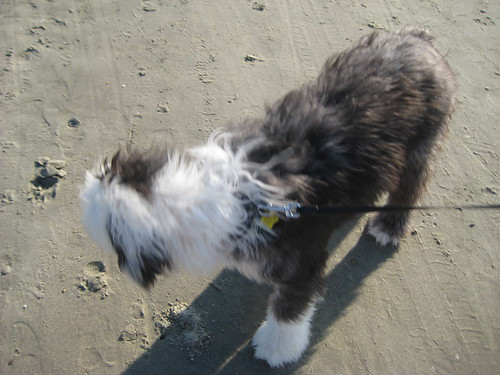

In [6]:
# show the orignal image 
index = 2
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
input_image

In [7]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [200 229 155] ['Tibetan terrier, chrysanthemum dog', 'Old English sheepdog, bobtail', 'Shih-Tzu']
Raw class scores: [10.186101  8.509349  8.472935]


### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully.
 + More on [autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) and [hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks)
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | - 
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

### Complementary questions:

##### Try GradCAM on others convolutional layers, describe and comment the results

In [8]:
# Your code here
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the resnet152
        self.resnet = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        
        return x

In [9]:
def get_grad_cam_image(img, img_name, pred, index_category, model):

    # get the gradient of the output with respect to the parameters of the model
    pred[:, index_category].backward(retain_graph=True)

    # pull the gradients out of the model
    gradients = model.get_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(img).detach()
    
    # weight the channels by corresponding gradients
    for i in range(len(pooled_gradients)): # for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # make the heatmap to be a numpy array
    heatmap = heatmap.numpy()

    # interpolate the heatmap
    img = cv2.imread(f'./data/TP2_images/{img_name}')
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img

    if not os.path.exists("grad_cam_images"):
        os.mkdir("grad_cam_images")
    cv2.imwrite(f'./grad_cam_images/{img_name}', superimposed_img)

    grad_cam_img = cv2.imread(f'./grad_cam_images/{img_name}')
    grad_cam_img = cv2.cvtColor(grad_cam_img, cv2.COLOR_BGR2RGB)
    
    return grad_cam_img

In [10]:
def plot_result_grad_cam(index, Model=ResNet()):
    # init the resnet
    resnet = Model

    # set the evaluation mode
    _ = resnet.eval()

    index = index
    img = dataset[index][0].view(1, 3, 224, 224)
    img_name = dataset.imgs[index][0].split('/')[-1] #dataset.imgs[index][0][12:-4]

    # forward pass
    pred = resnet(img)

    values, indices = torch.topk(pred, 3)
    print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
    print("Raw class scores:", values[0].detach().numpy())

    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    for i, index_class_pred in enumerate(indices[0].numpy()):
        grad_cam_image = get_grad_cam_image(img=img, img_name=img_name, pred=pred, index_category=index_class_pred, model=resnet)
        axs[i].imshow(grad_cam_image)
        axs[i].set_title(f"GradCam plot for \n '{classes[index_class_pred]}'")

Top 3-classes: [334 377 297] ['porcupine, hedgehog', 'marmoset', 'sloth bear, Melursus ursinus, Ursus ursinus']
Raw class scores: [11.207968   9.872371   7.2544484]


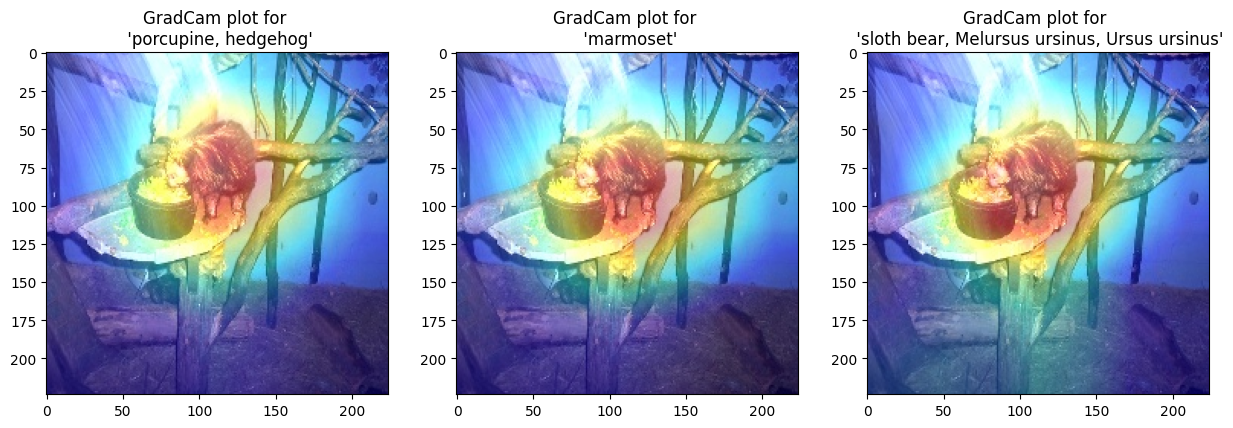

In [11]:
plot_result_grad_cam(index=1)

Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [13.077123 10.977324 10.554376]


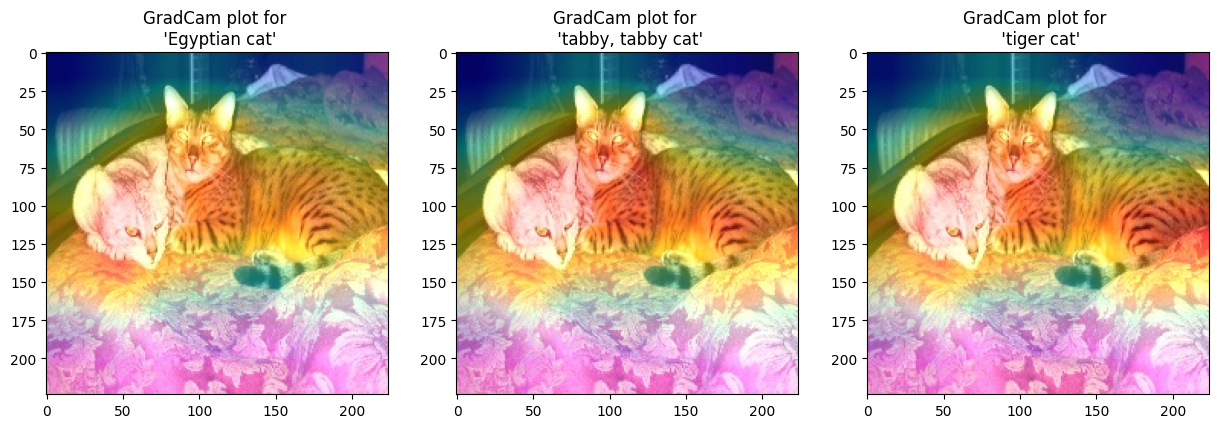

In [12]:
plot_result_grad_cam(index=5)

Top 3-classes: [339 345 253] ['sorrel', 'ox', 'basenji']
Raw class scores: [16.298988  8.744853  8.430347]


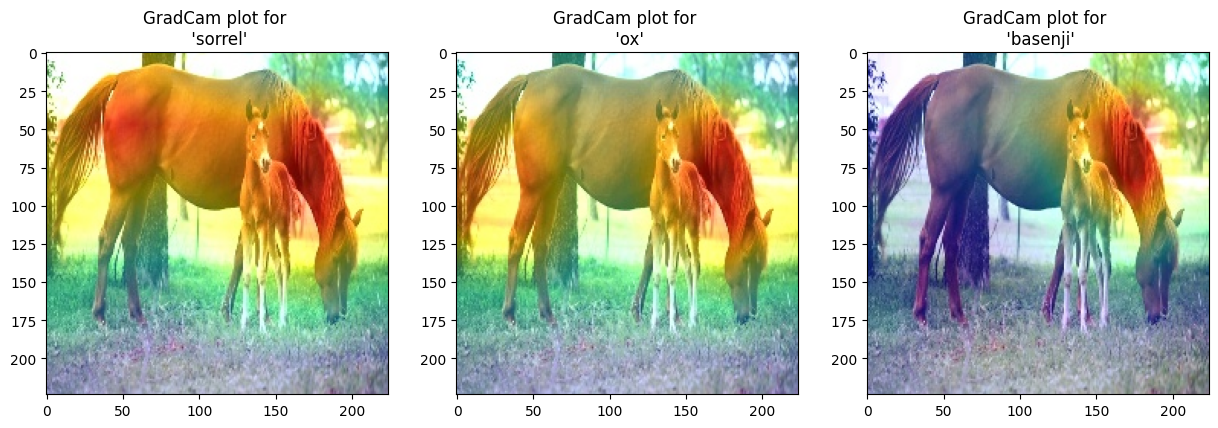

In [13]:
plot_result_grad_cam(index=10)

##### Try GradCAM on others convolutional layers, describe and comment the results

In [14]:
# Your code here
class ResNet_layer3(nn.Module):
    def __init__(self):
        super(ResNet_layer3, self).__init__()
        
        # define the resnet152
        self.resnet = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      )
        
        self.layer4=self.resnet.layer4
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        x=self.layer4(x)
        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        
        return x

In [15]:
# Your code here
class ResNet_layer2(nn.Module):
    def __init__(self):
        super(ResNet_layer2, self).__init__()
        
        # define the resnet152
        self.resnet = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      )
        
        self.layer3=self.resnet.layer3
        self.layer4=self.resnet.layer4
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        x=self.layer3(x)
        x=self.layer4(x)
        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        
        return x

Top 3-classes: [334 377 297] ['porcupine, hedgehog', 'marmoset', 'sloth bear, Melursus ursinus, Ursus ursinus']
Raw class scores: [11.207968   9.872371   7.2544484]


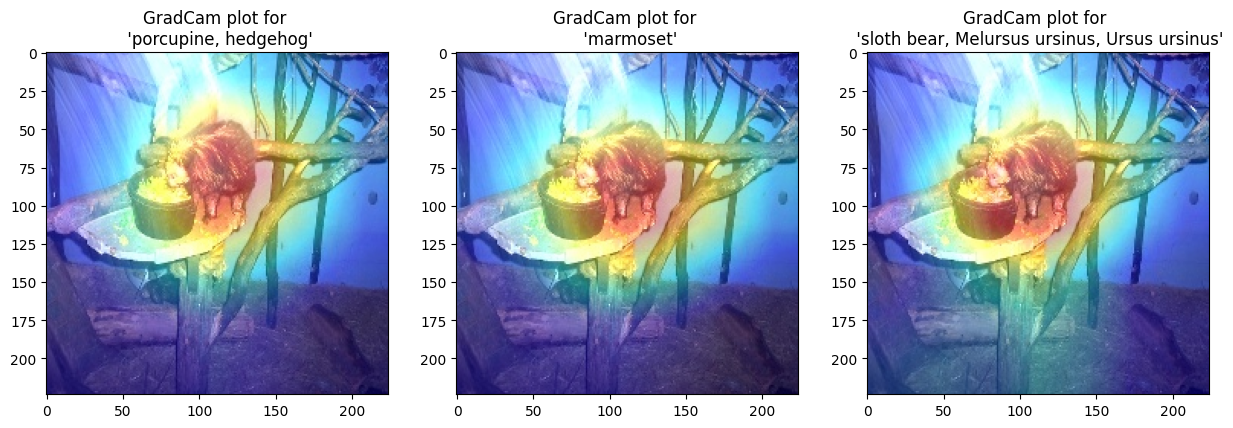

In [16]:
plot_result_grad_cam(index=1)

Top 3-classes: [334 377 297] ['porcupine, hedgehog', 'marmoset', 'sloth bear, Melursus ursinus, Ursus ursinus']
Raw class scores: [11.207968   9.872371   7.2544484]


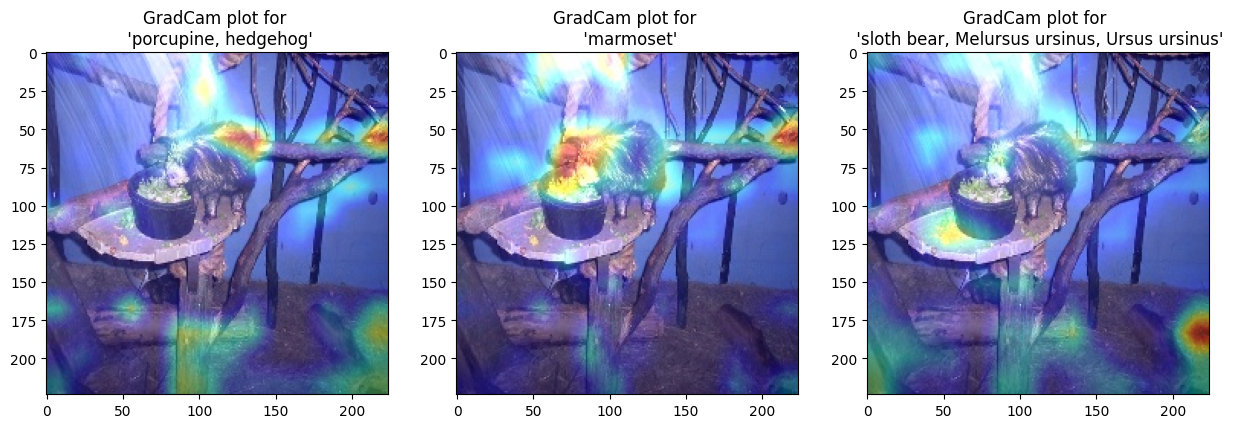

In [17]:
plot_result_grad_cam(index=1,Model=ResNet_layer3())

Top 3-classes: [334 377 297] ['porcupine, hedgehog', 'marmoset', 'sloth bear, Melursus ursinus, Ursus ursinus']
Raw class scores: [11.207968   9.872371   7.2544484]


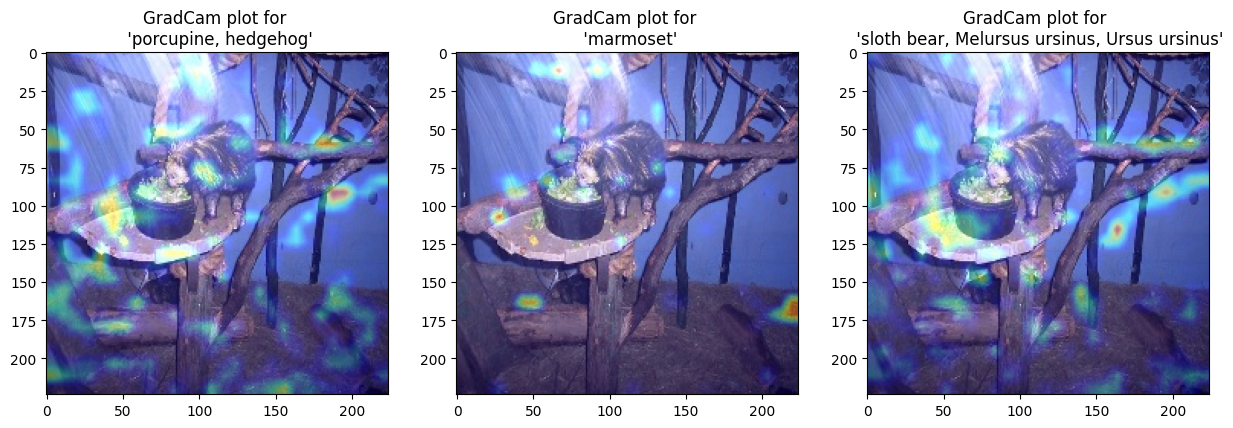

In [18]:
plot_result_grad_cam(index=1,Model=ResNet_layer2())

The more we go deep with gradCam more we loose in precision. This reflect the fact that there is a lack of information if we consider only the first layers, we loose the information in the last layers.


##### What are the principal contributions of GradCAM (the answer is in the paper) ?

Unlike previous methods that produced heatmaps for object localization, GradCAM introduces a technique for generating pixel-level importance maps that effectively localize the discriminative image regions responsible for the model's prediction.

Moreover, GradCAM enhances the interpretability of deep neural networks by producing visualizations that facilitate human comprehension of the model's decision-making process, making it easier to trust and understand the model's predictions.

In addition GradCAM is compatible with any CNN-based architecture without requiring architectural changes or additional training, making it widely applicable across various deep learning models and tasks.